# A Brief Review of Radiation

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________
<a id='section1'></a>

## 1. Emission temperature and lapse rates
____________

Planetary energy balance is the foundation for all climate modeling. So far we have expressed this through a globally averaged budget

$$C \frac{d T_s}{dt} = (1-\alpha) Q - OLR$$

and we have written the OLR in terms of an emission temperature $T_e$ where by definition

$$ OLR = \sigma T_e^4 $$

Using values from the observed planetary energy budget, we found that $T_e = 255$ K

The emission temperature of the planet is thus about 33 K colder than the mean surface temperature (288 K).

### Where in the atmosphere do we find $T = T_e = 255$ K?

That's about -18ºC.

Let's plot **global, annual average observed air temperature** from NCEP reanalysis data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
## The NOAA ESRL server is shutdown! January 2019
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc",
                          use_cftime=True)
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/pressure/air'
#air = xr.open_dataset(url)
## The name of the vertical axis is different than the NOAA ESRL version..
#ncep_air = air.rename({'lev': 'level'})
print( ncep_air)

<xarray.Dataset>
Dimensions:             (lat: 73, level: 17, lon: 144, nbnds: 2, time: 12)
Coordinates:
  * level               (level) float32 1000.0 925.0 850.0 ... 30.0 20.0 10.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:      

In [3]:
#  Take global, annual average and convert to Kelvin
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
Tglobal

<xarray.DataArray (level: 17)>
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0

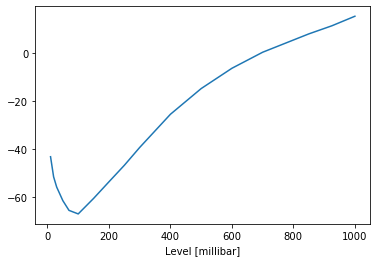

In [4]:
#  a "quick and dirty" visualization of the data
Tglobal.plot()

Let's make a better plot.

Here we're going to use a package called `metpy` to automate plotting this temperature profile in a way that's more familiar to meteorologists: a so-called *skew-T* plot.

In [5]:
from metpy.plots import SkewT

Text(0.5, 1.0, 'Global, annual mean sounding from NCEP Reanalysis')

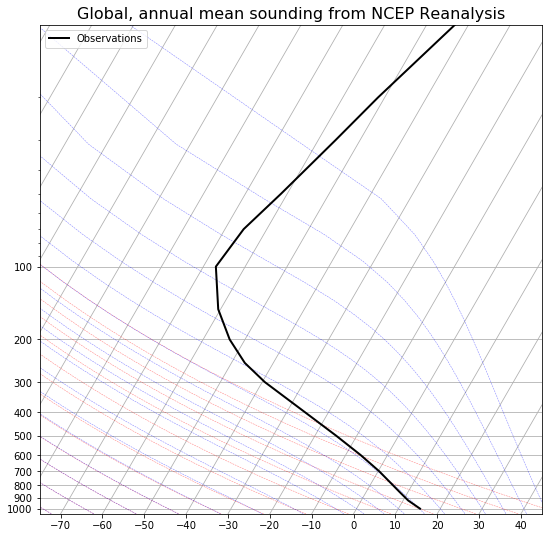

In [6]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)
skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
skew.ax.set_ylim(1050, 10)
skew.ax.set_xlim(-75, 45)
# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.5)
skew.plot_moist_adiabats(linewidth=0.5)
#skew.plot_mixing_lines()
skew.ax.legend()
skew.ax.set_title('Global, annual mean sounding from NCEP Reanalysis', 
             fontsize = 16)

Note that surface temperature in global mean is indeed about 288 K or 15ºC as we keep saying.

So where do we find temperature $T_e=255$ K or -18ºC?

Actually in mid-troposphere, near 500 hPa or about 5 km height.

We can infer that much of the outgoing longwave radiation actually originates far above the surface.

Recall that our observed global energy budget diagram shows 217 out of 239 W m$^{-2}$ total OLR emitted by the atmosphere and clouds, only 22 W m$^{-2}$ directly from the surface.

This is due to the **greenhouse effect**. 

So far we have dealt with the greenhouse in a very artificial way in our energy balance model by simply assuming 

$$ \text{OLR} = \tau \sigma T_s^4 $$

i.e., the OLR is reduced by a constant factor from the value it would have if the Earth emitted as a blackbody at the surface temperature.

Now it's time to start thinking a bit more about how the radiative transfer process actually occurs in the atmosphere, and how to model it.

____________
<a id='section2'></a>

## 2. Solar Radiation
____________

Let's plot a spectrum of solar radiation.

For Python details, click to expand the code blocks (or see the code in the notebook).

In [7]:
#  Using pre-defined code for the Planck function from the climlab package
from climlab.utils.thermo import Planck_wavelength

In [8]:
# approximate emission temperature of the sun in Kelvin
Tsun = 5780.
# boundaries of visible region in nanometers
UVbound = 390.
IRbound = 700.
#  array of wavelengths
wavelength_nm = np.linspace(10., 3500., 400)
to_meters = 1E-9  # conversion factor

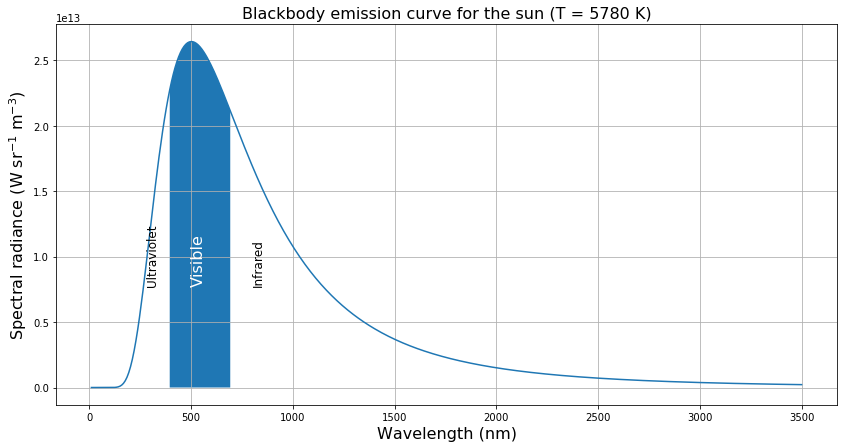

In [9]:
label_size = 16
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(wavelength_nm, 
         Planck_wavelength(wavelength_nm * to_meters, Tsun))
ax.grid()
ax.set_xlabel('Wavelength (nm)', fontsize=label_size)
ax.set_ylabel('Spectral radiance (W sr$^{-1}$ m$^{-3}$)', fontsize=label_size)
#  Mask out points outside of this range
wavelength_vis = np.ma.masked_outside(wavelength_nm, UVbound, IRbound)
#  Shade the visible region
ax.fill_between(wavelength_vis, Planck_wavelength(wavelength_vis * to_meters, Tsun))
title = 'Blackbody emission curve for the sun (T = {:.0f} K)'.format(Tsun)
ax.set_title(title, fontsize=label_size);
ax.text(280, 0.8E13, 'Ultraviolet', rotation='vertical', fontsize=12)
ax.text(500, 0.8E13, 'Visible', rotation='vertical', fontsize=16, color='w')
ax.text(800, 0.8E13, 'Infrared', rotation='vertical', fontsize=12);

- Spectrum peaks in the visible range
- most energy at these wavelength.
- No coincidence that our eyes are sensitive to this range of wavelengths!
- Longer wavelengths called “infrared”, shorter wavelengths called “ultraviolet”.

The shape of the spectrum is a fundamental characteristic of radiative emissions
(think about the color of burning coals in a fire – cooler = red, hotter = white)

Theory and experiments tell us that both the total flux of emitted radiation, and the wavelength of maximum emission, depend only on the temperature of the source!

The theoretical spectrum was worked out by Max Planck and is therefore known as the “Planck” spectrum (or simply blackbody spectrum).

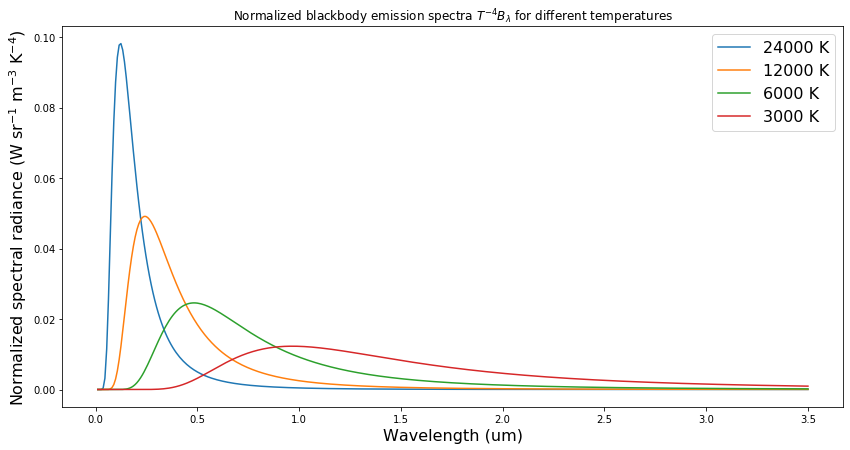

In [10]:
fig, ax = plt.subplots(figsize=(14,7))
wavelength_um = wavelength_nm / 1000
for T in [24000,12000,6000,3000]:
    ax.plot(wavelength_um, 
         (Planck_wavelength(wavelength_nm * to_meters, T) / T**4),
           label=str(T) + ' K')
ax.legend(fontsize=label_size)
ax.set_xlabel('Wavelength (um)', fontsize=label_size)
ax.set_ylabel('Normalized spectral radiance (W sr$^{-1}$ m$^{-3}$ K$^{-4}$)', fontsize=label_size)
ax.set_title("Normalized blackbody emission spectra $T^{-4} B_{\lambda}$ for different temperatures");

Going from cool to warm:

- total emission increases
- maximum emission occurs at shorter wavelengths.

The **integral of these curves over all wavelengths** gives us our familiar $\sigma T^4$

Mathematically it turns out that 

$$ λ_{max} T = \text{constant} $$

(known as Wien’s displacement law).

By fitting the observed solar emission to a blackbody curve, we can deduce that the emission temperature of the sun is about 6000 K.

Knowing this, and knowing that the solar spectrum peaks at 0.6 micrometers, we can calculate the wavelength of maximum terrestrial radiation as

$$ λ_{max}^{Earth} = 0.6 ~ \mu m \frac{6000}{255} = 14 ~ \mu m $$

This is in the far-infrared part of the spectrum.

____________
<a id='section3'></a>

## 3. Terrestrial Radiation and absorption spectra
____________

## Terrestrial versus solar wavelengths

Now let's look at normalized blackbody curves for Sun and Earth:

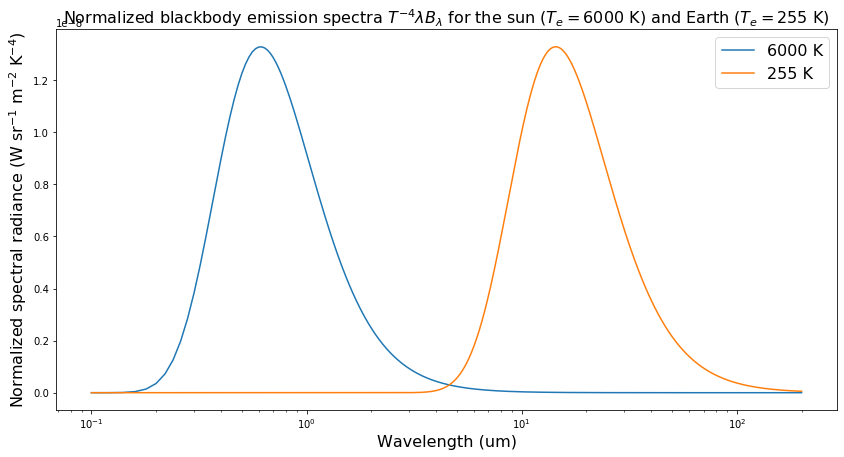

In [11]:
fig, ax = plt.subplots(figsize=(14,7))
wavelength_um = np.linspace(0.1, 200, 10000)
wavelength_meters = wavelength_um / 1E6

for T in [6000, 255]:
    ax.semilogx(wavelength_um, 
         (Planck_wavelength(wavelength_meters, T) / T**4 * wavelength_meters),
           label=str(T) + ' K')
ax.legend(fontsize=label_size)
ax.set_xlabel('Wavelength (um)', fontsize=label_size)
ax.set_ylabel('Normalized spectral radiance (W sr$^{-1}$ m$^{-2}$ K$^{-4}$)', fontsize=label_size)
ax.set_title("Normalized blackbody emission spectra $T^{-4} \lambda B_{\lambda}$ for the sun ($T_e = 6000$ K) and Earth ($T_e = 255$ K)",
            fontsize=label_size);

There is essentially no overlap between the two spectra.

**This is the fundamental reason we can discuss the solar “shortwave” and terrestrial “longwave” radiation as two distinct phenomena.**

In reality all radiation exists on a continuum of different wavelengths. But in climate science we can get a long way by thinking in terms of a very simple “two-stream” approximation (short and longwave). We’ve already been doing this throughout the course so far!

### Atmospheric absorption spectra

Now look at the atmospheric **absorption spectra**.

(fraction of radiation at each wavelength that is absorbed on a single vertical path through the atmosphere)

<img src='../images/MarshallPlumbFig2.5.png'>

*Figure reproduced from Marshall and Plumb (2008): Atmosphere, Ocean, and Climate Dynamics*

- Atmosphere is almost completely transparent in the visible range, right at the peak of the solar spectrum
- Atmosphere is very opaque in the UV
- Opacity across the IR spectrum is highly variable!
- Look at the gases associated with various absorption features:
- Main players include H$_2$O, CO$_2$, N$_2$O, O$_2$.
- Compare to major constituents of atmosphere, in decreasing order: 
    - 78% N$_2$
    - 21% O$_2$
    - 1% Ar
    - H$_2$O (variable) 

- The dominant constituent gases N$_2$ and O$_2$ are nearly completely transparent across the entire spectrum (there are O$_2$ absorption features in far UV, but little energy at these wavelengths).
- The greenhouse effect mostly involves trace constituents: 
    - O$_3$ = 500 ppb
    - N$_2$O = 310 ppb
    - CO$_2$ = 400 ppm (but rapidly increasing!)
    - CH$_4$ = 1.7 ppm
- Note that most of these are tri-atomic molecules! There are fundamental reasons for this: these molecules have modes of rotational and vibration that are easily excited at IR wavelengths. See courses in radiative transfer!


____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________